In [335]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from scipy.stats import norm 
from scipy.ndimage import gaussian_filter1d
from scipy import linalg

In [2]:
V_rest = -70.0 # mV, resting membrane potential 

In [3]:
dt = 0.1 # ms, simulation time step 

In [4]:
# tau 
tau_E = 20.0 # ms, E neuron time constant 
tau_I = 10.0 # ms, I neuron time constant 

In [5]:
tau_syn = 2.0 # ms, synaptic time constant 

In [7]:
k = 0.3 # mV^-n*s^-1, nonlinearity gain 
n = 2 # nonlinearity exponent

In [418]:
def get_noise(N_E,
              N_I,
             n_steps, 
             scale = 1,
             sigma_0E = 1.0, # mV, noise standard deviation 
             sigma_0I = 0.5, # mV, noise standard deviation
             tau_E = 20.0, # ms, E neuron time constant 
             tau_I = 10.0, # ms, I neuron time constant 
             tau_noise = 50.0, # ms, noise correlation time constant 
             pho = 0.2, # pairwise correlation coefficient
             dt = 0.1):
    """
    Generate noise for each unit in the spiking two population model 
    """
    # construct sigma_noise
    N = N_E + N_I
    sigma_noise = np.ones((N, N))
    #sigma_E = (np.power(sigma_0E,2))*(1+tau_E/tau_noise)
    #sigma_I = (np.power(sigma_0I,2))*(1+tau_I/tau_noise)
    sigma_E = 0.1**2
    sigma_I = 0.1**2
    for i in range(N_E):
        sigma_noise[i,:] = sigma_E * pho
    for i in range(N_E, N):
        sigma_noise[i,:] = sigma_I * pho
        
    for i in range(N_E):
        sigma_noise[i,i] = sigma_E
    for i in range(N_E, N):
        sigma_noise[i,:] = sigma_I
    
    noise_list = np.empty((N, n_steps))
    
    # initialize 
    noise = np.zeros((N,))
    
    r = norm.rvs(size=(N, n_steps), scale=scale)
    
    for i_step in range(n_steps):
        
        #d_noise = (-noise*dt+(linalg.sqrtm(2*tau_noise*sigma_noise)).dot(r[:,i_step]))/tau_noise
        d_noise = (-noise*dt+(np.sqrt(2*tau_noise*sigma_noise)).dot(r[:,i_step]))/tau_noise
        noise = noise + d_noise 
        noise_list[:, i_step] = noise
        
    return noise_list

In [382]:
def plot_figure_3_a(R_list, 
                    V_list,
                    spike_time_list, 
                    N_E = 4000, 
                    N_I = 1000,
                    gaussian_smooth_width = 50):
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,8), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    
    # raster plot 
    exc_colors = ['red' for i in range(40)]
    inh_colors = ['blue' for i in range(10)]
    colors = np.concatenate((inh_colors, exc_colors))
    exc = spike_time_list[:40]
    inh = spike_time_list[-10:]
    spike_time_plot = np.concatenate((inh, exc))
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.eventplot(spike_time_plot, colors=colors)
    
    # population firing rate 
    exc_R_list = R_list[:N_E,:]
    exc_R_mean = np.mean(exc_R_list, axis=0)
    exc_R_smoothed = gaussian_filter1d(exc_R_mean, gaussian_smooth_width/dt)
    
    inh_R_list = R_list[N_E:, :]
    inh_R_mean = np.mean(inh_R_list, axis=0)
    inh_R_smoothed = gaussian_filter1d(inh_R_mean, gaussian_smooth_width/dt)

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.set_ylabel('population rate [Hz]', fontsize=12)
    #ax2.plot(exc_R_smoothed, color='red')
    #ax2.plot(inh_R_smoothed, color='blue')
    ax2.plot(exc_R_mean, color='red')
    ax2.plot(inh_R_mean, color='blue')
    
    # LFP 
    LFP_list = np.mean(V_list, axis=0)
    LFP_smoothed = gaussian_filter1d(LFP_list, gaussian_smooth_width/dt)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.plot(LFP_smoothed)
    ax3.set_ylabel('LFP [mV]', fontsize=12)
    
    # Vm 
    neuron_1_trace = V_list[0]
    neuron_1_trace_smoothed = gaussian_filter1d(neuron_1_trace, gaussian_smooth_width/dt)
    neuron_2_trace = V_list[1]
    neuron_2_trace_smoothed = gaussian_filter1d(neuron_2_trace, gaussian_smooth_width/dt)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.plot(neuron_1_trace_smoothed, color='blue', label='neuron 1')
    ax4.plot(neuron_2_trace_smoothed, color='yellow', label='neuron 2')
    ax4.legend()

In [419]:
def get_connectivity(N_E, 
                    N_I,
                    p_E = 0.1, # connection probability for E presynaptic partners 
                    p_I = 0.4, # connection probability for I presynaptic partners
                    W_EE = 1.25, # mV*s, connection weight
                    W_IE = 1.2, # mV*s, connection weight
                    W_EI = -0.65, # mV*s, connection weight
                    W_II = -0.5, # mV*s, connection weight
                    tau_syn = 2.0 # ms, synaptic time constant
                    ):
    
    # checked 
    
    tau_syn = tau_syn/1000 # convert unit 
    
    # get synaptic weight 
    J_EE = W_EE/(tau_syn*p_E*N_E)
    J_IE = W_IE/(tau_syn*p_E*N_E)
    J_EI = W_EI/(tau_syn*p_I*N_I)
    J_II = W_II/(tau_syn*p_I*N_I)
    
    # count of E and I presynaptic partners 
    count_E = int(p_E*N_E)
    count_I = int(p_I*N_I)
    
    W = np.zeros((N_E+N_I, N_E+N_I))
    
    for i_E in range(N_E):
        # E -> E 
        pre_part_E = np.random.choice(N_E, count_E, replace=False)
        W[i_E,pre_part_E] = J_EE
        
        # I -> E 
        pre_part_I = N_E + np.random.choice(N_I, count_I, replace=False)
        W[i_E, pre_part_I] = J_EI 
        
    for i_I in range(N_I):
        # E -> I 
        pre_part_E = np.random.choice(N_E, count_E, replace=False)
        W[i_I+N_E,pre_part_E] = J_IE
        
        # I -> I 
        pre_part_I = N_E + np.random.choice(N_I, count_I, replace=False)
        W[i_I+N_E, pre_part_I] = J_II 
        
    return W       

In [414]:
W = get_connectivity(N_E=4000, N_I=1000)
# need to stimulate with 4000 and 1000 to get the right W! 

In [415]:
W

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    , -0.8125],
       [ 1.5625,  0.    ,  0.    , ...,  0.    , -0.8125, -0.8125],
       [ 0.    ,  0.    ,  0.    , ...,  0.    , -0.8125,  0.    ],
       ...,
       [ 1.5   ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  1.5   , ...,  0.    , -0.625 ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ..., -0.625 , -0.625 , -0.625 ]])

In [420]:
def simulate_spiking_model(n_steps,
                          N_E = 4000,
                          N_I = 1000,
                          h = 2.0 # mV,input baseline
                          ):

    # record 
    N = N_E+N_I
    V_list = np.empty((N, n_steps))
    R_list = np.empty((N, n_steps))
    spike_time_list = [[] for i in range(N)]
    spike_raster = np.zeros((N, n_steps))
    A_list = np.empty((N, n_steps))

    # Initialize 
    # Initial potential for all neurons 
    V = V_rest*np.ones((N,1))
    V_rest_vec = V_rest*np.ones((N,1))

    # H: input
    H = h*np.ones((N,1))

    # noise 
    noise_list = get_noise(N_E=N_E, N_I=N_I, n_steps=n_steps, scale=0.5)
    #noise_list = np.zeros((N, n_steps))

    # tau 
    tau = np.concatenate((tau_E*np.ones((N_E,1)), tau_I*np.ones((N_I,1))), axis=0)

    # postsynaptic current 
    A = np.zeros((N,1))

    # spike 
    axon_delay = 0.5/dt # axon delay 

    # connectivity
    W = get_connectivity(N_E=N_E, N_I=N_I)

    for i_step in range(n_steps):
    
        # get noise 
        noise = noise_list[:, i_step]
        noise = np.asarray(noise)
        noise = noise.reshape(N_E+N_I,1)
    
        # update postsynaptic currents 
        if i_step >= axon_delay:
            A_spike = spike_raster[:, i_step-5]
            A_spike = A_spike.reshape((N,1))
        else:
            A_spike = np.zeros((N,1))
        dA = dt*(-A/tau_syn + A_spike)
        A = A+dA
        A_list[:, i_step] = A.reshape(N,)
    
        # get momentary firing rate 
        R = k*np.power(np.maximum(0.0, np.floor(V-V_rest_vec)), n)
        R_list[:, i_step] = R.reshape(N,)
    
        # simulate firing 
        prob_spike = dt*R
        spike = np.zeros((N,1))
        for ind, i_p in enumerate(prob_spike):
            if np.random.random()<i_p: # if spike 
                spike_time_list[ind].append(i_step)
                spike[ind] = 1 
        spike_raster[:,i_step] = spike.reshape((N,))
        
        # update V 
        V_list[:, i_step]=V.reshape((N,))
        dV = np.divide(dt*(-V + V_rest_vec + H + noise + W.dot(A)), tau)
        V = V + dV
        
    return R_list, V_list, spike_time_list, spike_raster

In [421]:
[R_list, V_list, spike_time_list, A_list] = simulate_spiking_model(n_steps=2000,h = 2.0)

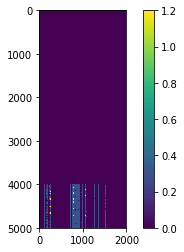

In [422]:
plt.imshow(R_list)
plt.colorbar()

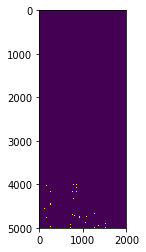

In [423]:
plt.imshow(A_list)

ValueError: all the input arrays must have same number of dimensions

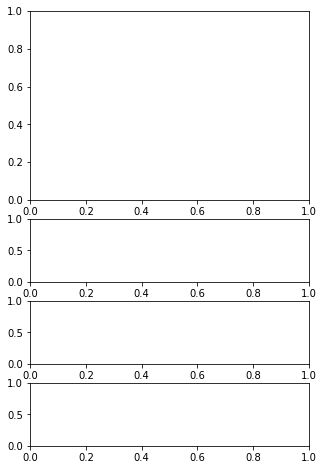

In [424]:
plot_figure_3_a(R_list, V_list,spike_time_list)